In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [7]:
from misc import Prob, Basics
import matplotlib.pyplot as plt
basics = Basics(dolinar_layers=2)
ats = basics.ats

def pn1(n,beta,alpha=0.4):
    p=0
    for pm in [-1,1]:
        p+=Prob(pm*alpha, beta,n)
    return p

def Q2(b1,n1,b2,alpha=0.4):
    p=0
    for n2 in [0,1]:
        p+=max([Prob(pm*alpha*np.cos(ats[0]), b1,n1)*Prob(pm*alpha*np.sin(ats[0]), b2,n2) for pm in [-1.,1.]])
    p/=pn1(n1,b1)
    return p

def Q1(b1,alpha=0.4):
    p=0
    for n1 in [0,1]:
        p+= max([Q2(b1,n1,b2,alpha) for b2 in np.arange(-1,1,.05)])*pn1(n1,b1)
    return p/2

betas = np.arange(-1,1,.01)


@tf.function
def train_step(data, labels):
    with tf.GradientTape() as tape:
        tape.watch(net.trainable_variables)
        preds = net(tf.convert_to_tensor(data))
        loss = tf.reduce_mean(tf.keras.losses.MSE(labels, preds))
        grads = tape.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    return loss

In [8]:
from nets import RNNC

In [9]:
net = RNNC()
b1 = -.7
n1=1
data =[]
labels=[]
for b2 in betas:
    for n1 in [0,1]:
        label = Q2(b1,n1,b2)
        data.append([b1,n1,b2])
        labels.append(label)
labels=np.array(labels).astype(np.float32)
data_all = np.reshape(data, (len(data),1,3)).astype(np.float32)
labels_all = np.reshape(labels, (len(labels),1,1))
optimizer = tf.keras.optimizers.Adam(lr=0.01)
dat_set = tf.data.Dataset.from_tensor_slices((data_all,labels_all))

100%|██████████| 10000/10000 [02:33<00:00, 65.17it/s]



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



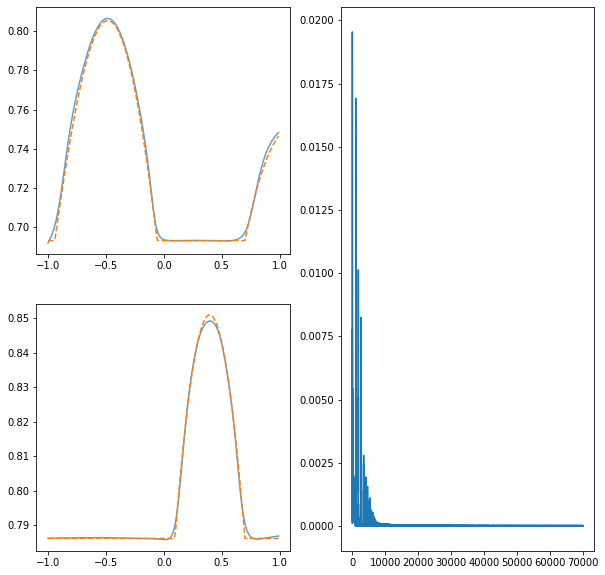

In [10]:
l=[]
for k in tqdm(range(10**4)):
    dat_set.shuffle(buffer_size=len(data_all))    
    for k1,k2 in list(dat_set.batch(64)):
        l.append(train_step(k1,k2).numpy())    
        
plt.figure(figsize=(10,10))


ax1=plt.subplot2grid((2,2),(0,0))
ax2=plt.subplot2grid((2,2),(1,0))
ax3=plt.subplot2grid((2,2),(0,1),rowspan=2)

axs = [ax1,ax2]
data_test = {}
for n,ax in zip([0,1],axs):
    data_test[str(n)] = []
    for b in betas:
        data_test[str(n)].append([b1,n,b])
    data_test[str(n)]=np.reshape(data_test[str(n)], (len(data_test[str(n)]), 1,3))

    ax.plot(betas, np.squeeze(net(data_test[str(n)])), alpha=0.7)
    ax.plot(betas, [Q2(b1,n,b) for b in betas], '--', label="Q2")
ax3.plot(l)